<a href="https://colab.research.google.com/github/JNK234/100-days-of-deep-learning/blob/main/Day%205/Detecting_Unknown_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 


## Imports

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import to_fp16

## Data

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [5]:
path = (path/'images')
path.ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_159.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_47.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_109.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_57.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_15.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_1.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_104.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_27.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_181.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_97.jpg')...]

In [6]:
path.ls()[0]

Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_159.jpg')

## DataBlock 

In [7]:
pets = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    get_y=Pipeline([RegexLabeller(r'([^/]+)_\d+.jpg$'), lambda label: [label]]),
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [8]:
dls = pets.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


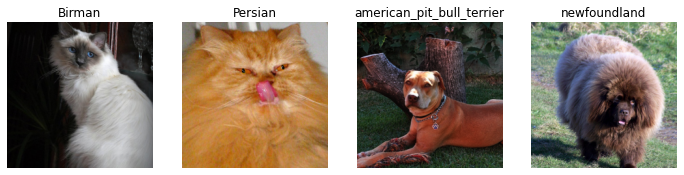

In [9]:
dls.show_batch(nrows=1, ncols=4)

## Model Training

In [10]:
learn = cnn_learner(dls, resnet50, 
                    loss_func=BCEWithLogitsLossFlat(), 
                    metrics=partial(accuracy_multi, thresh=0.95)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(valley=0.002511886414140463)

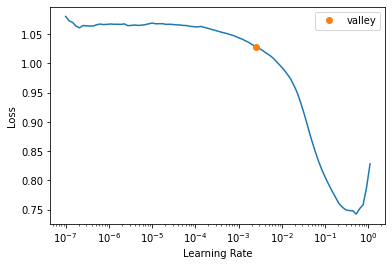

In [11]:
learn.lr_find()

In [12]:
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.610650,0.094275,0.978697,02:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.071185,0.024539,0.982847,03:20
1,0.031587,0.011863,0.989943,03:18
2,0.017639,0.010456,0.991826,03:18


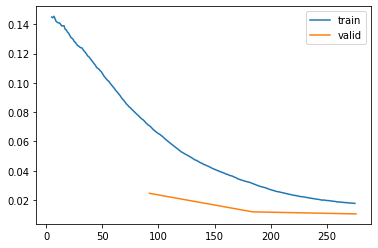

In [13]:
learn.recorder.plot_loss()

In [24]:
print(dls.vocab)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [17]:
x,y = dls.one_batch()

In [18]:
y

TensorMultiCategory([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [19]:
print(y[0])

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], device='cuda:0')


## Checking results

In [20]:
learn.loss_func = BCEWithLogitsLossFlat(thresh=0.95)

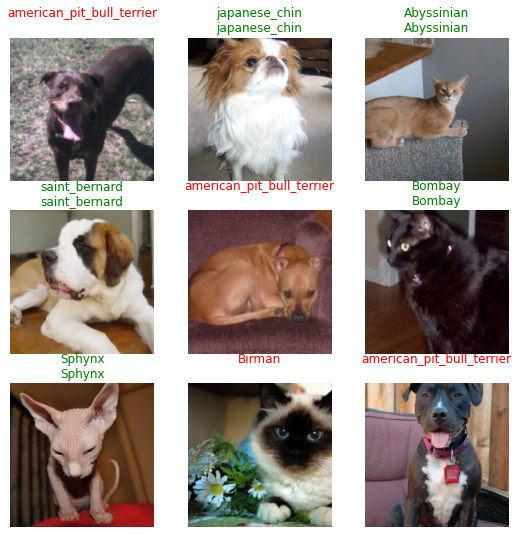

In [25]:
learn.show_results()

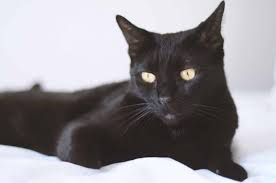

In [30]:
img = PILImage.create('Bombay.jpg')
img

In [31]:
learn.predict(img)

((#1) ['Bombay'],
 TensorBase([False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]),
 TensorBase([2.9350e-03, 2.8672e-03, 4.3056e-04, 9.9959e-01, 2.0428e-03, 1.3994e-03,
         1.5248e-03, 4.1569e-04, 1.5012e-03, 2.0112e-03, 1.5978e-03, 3.8446e-04,
         5.2338e-04, 1.1514e-03, 3.9666e-04, 5.1126e-04, 6.7456e-04, 5.0728e-04,
         5.2954e-04, 8.7277e-04, 7.2084e-04, 1.5978e-03, 7.4953e-04, 4.7285e-04,
         5.2542e-04, 6.0708e-04, 2.4157e-04, 2.0348e-03, 7.7633e-04, 3.2251e-04,
         5.1527e-04, 4.3056e-04, 1.3302e-03, 6.1183e-04, 4.8030e-04, 5.5278e-04,
         7.1245e-04]))

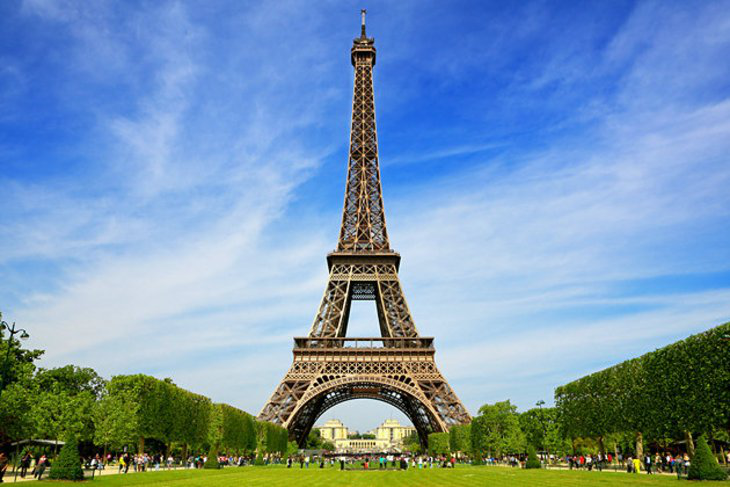

In [33]:
tower = PILImage.create('eiffel-tower.jpg')
tower

In [35]:
learn.predict(tower)

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]),
 TensorBase([0.0070, 0.0346, 0.0041, 0.0286, 0.0016, 0.0079, 0.0654, 0.0071, 0.0113,
         0.0070, 0.0025, 0.0072, 0.0041, 0.0044, 0.0033, 0.0092, 0.0047, 0.0020,
         0.0868, 0.0018, 0.0101, 0.0024, 0.0103, 0.0042, 0.0034, 0.0023, 0.0121,
         0.0037, 0.0036, 0.0064, 0.0045, 0.0103, 0.0636, 0.0086, 0.0041, 0.0077,
         0.0050]))

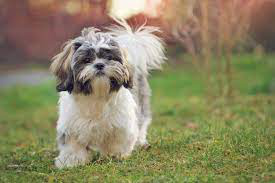

In [36]:
dog = PILImage.create('Shihtzu.jpg')
dog

In [38]:
learn.predict(dog)

((#0) [],
 TensorBase([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False]),
 TensorBase([0.0020, 0.0033, 0.0025, 0.0032, 0.0020, 0.0025, 0.0019, 0.0068, 0.0025,
         0.0030, 0.0017, 0.0022, 0.0027, 0.0060, 0.0022, 0.0024, 0.0044, 0.0051,
         0.0020, 0.0030, 0.0015, 0.0018, 0.8748, 0.0086, 0.0022, 0.0019, 0.0013,
         0.0020, 0.0046, 0.0051, 0.0029, 0.0014, 0.0023, 0.0009, 0.0028, 0.0034,
         0.1438]))